In [1]:
import sys

In [2]:
sys.executable

'/home/ubuntu/anaconda3/envs/scgpt_conda/bin/python'

In [3]:
import numpy

In [181]:
import scgpt; # silencing the warning about flash attention
# - kind of a pain to install and won't need it unless training

In [5]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

In [6]:
import torch
from anndata import AnnData
import scanpy as sc
import numpy as np

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm

In [8]:
import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

In [9]:
sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

In [11]:
# setting parameters, seed value, num highly variable genes, num bins, etc
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

In [14]:
model_dir = Path("../scGPT_bc")

In [15]:
model_config_file = model_dir / "args.json"
model_config_file

PosixPath('../scGPT_bc/args.json')

In [16]:
model_file = model_dir / "best_model.pt"
model_file

PosixPath('../scGPT_bc/best_model.pt')

In [17]:
vocab_file = model_dir / "vocab.json"

In [18]:
special_tokens

['<pad>', '<cls>', '<eoc>']

In [19]:
vocab = GeneVocab.from_file(vocab_file)

for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

In [20]:
vocab

GeneVocab()

In [21]:
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(f"resume model from {model_file} weights, model args override the {model_config_file} config")

resume model from ../scGPT_bc/best_model.pt weights, model args override the ../scGPT_bc/args.json config


In [22]:
# embedding size, number of attn heads, number of hidden dimensions, number of layers
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

In [23]:
embsize

512

In [24]:
nhead

8

In [25]:
d_hid

512

In [26]:
nlayers

12

In [27]:
n_layers_cls

3

In [28]:
gene2idx = vocab.get_stoi()

In [29]:
# each key is the gene and each value is the ID out of 36574 tokens
gene2idx

{'hsa-mir-423': 36570,
 'ZZEF1': 36564,
 'ZYX': 36563,
 'ZYG11A': 36561,
 'ZXDB': 36559,
 'ZXDA': 36558,
 'ZW10': 36555,
 'ZUP1': 36554,
 'ZSWIM9': 36553,
 'ZSWIM3': 36546,
 'ZSCAN5C': 36542,
 'ZSCAN5B': 36541,
 'ZSCAN26': 36533,
 'ZSCAN23': 36531,
 'ZSCAN22': 36530,
 'ZSCAN21': 36529,
 'ZSCAN2': 36527,
 'ZSCAN16-AS1': 36525,
 'ZSCAN16': 36524,
 'ZSCAN12': 36523,
 'ZRANB3': 36519,
 'ZRANB1': 36515,
 'ZPLD1': 36513,
 'ZP4': 36510,
 'ZP3': 36509,
 'ZP1': 36507,
 'ZNRF3': 36503,
 'ZNRF1': 36501,
 'ZNRD2-AS1': 36500,
 'ZNNT1': 36498,
 'ZNHIT3': 36496,
 'ZNHIT2': 36495,
 'ZNF99': 36492,
 'ZNF880': 36484,
 'ZNF879': 36483,
 'ZNF875': 36481,
 'ZNF865': 36480,
 'ZNF860': 36478,
 'ZNF853': 36477,
 'ZNF85': 36474,
 'ZNF846': 36473,
 'ZNF841': 36469,
 'ZNF84': 36467,
 'ZNF837': 36465,
 'ZNF835': 36463,
 'ZNF831': 36462,
 'ZNF830': 36461,
 'ZNF813': 36453,
 'ZNF808': 36451,
 'ZNF804B': 36449,
 'ZNF80': 36446,
 'ZNF8-DT': 36445,
 'ZNF8': 36444,
 'ZNF799': 36443,
 'ZNF793-AS1': 36442,
 'ZNF791': 364

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
device

device(type='cuda')

In [32]:
ntokens = len(vocab)
print(f"The size of the vocabulary is {ntokens}")

The size of the vocabulary is 36574


In [33]:
# create transformer model with specified configs
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value, 
    n_input_bins=n_input_bins)

In [34]:
# loaded the parameters from {model_file} 
try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load parameters that are in the model and match the correct size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {k : v for k, v in pretrained_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
    for k, v in pretrained_dict.items():
        print(f"Loading parameters {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading parameters encoder.embedding.weight with shape torch.Size([36574, 512])
Loading parameters encoder.enc_norm.weight with shape torch.Size([512])
Loading parameters encoder.enc_norm.bias with shape torch.Size([512])
Loading parameters value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading parameters value_encoder.linear1.bias with shape torch.Size([512])
Loading parameters value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading parameters value_encoder.linear2.bias with shape torch.Size([512])
Loading parameters value_encoder.norm.weight with shape torch.Size([512])
Loading parameters value_encoder.norm.bias with shape torch.Size([512])
Loading parameters transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading parameters transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading parameters transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading parame

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(36574, 512, padding_idx=36571)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [39]:
data_dir = Path("../data")

In [40]:
data_dir

PosixPath('../data')

In [67]:
# The gene embeddings are independent from the adata file above
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings_vec = gene_embeddings.detach().cpu().numpy()

In [68]:
# this is the gene embedding tensor datatype as visible to the first CUDA device
gene_embeddings

tensor([[-1.0721, -1.6595,  0.1648,  ..., -0.1175,  1.0547, -1.4533],
        [ 0.3351,  0.2272, -1.9701,  ..., -2.0266, -0.1298, -1.2059],
        [ 0.7244,  2.1800,  0.2197,  ..., -1.6308,  1.6810,  0.6335],
        ...,
        [ 0.3735, -1.2089, -1.0787,  ..., -0.5280,  0.7534, -1.0783],
        [ 0.4410,  0.8809, -0.3159,  ..., -1.4844, -0.5463, -0.5517],
        [ 1.1001,  1.2924,  1.1853,  ...,  0.2653, -0.6985, -0.4949]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [70]:
# grabbing gene embeddings vec which is the numpy array datatype version of the gene embeddings tensor (moved to the CPU and off of the GPU), looking at the first array in the array of arrays 
gene_embeddings_vec[0]

array([-1.0720766 , -1.6595243 ,  0.16481964,  0.53802264, -1.7331971 ,
        1.1035538 ,  0.78882325,  0.2515329 , -1.055454  , -0.00982814,
       -0.38119254, -1.4411521 ,  0.51102036, -1.7072881 ,  0.03995998,
       -0.39228812,  1.7824289 , -0.98842007,  2.0073097 , -1.6237841 ,
       -0.85830563, -0.9848164 ,  1.7606024 , -0.24607553,  0.9836976 ,
        0.7811537 , -0.11499887, -0.98964316, -1.4598908 , -0.78393626,
        1.9099872 ,  1.7788045 , -1.5616452 , -0.2519637 , -0.6474332 ,
       -0.30177927,  1.5840746 ,  1.6038415 ,  0.55698884, -0.6512232 ,
       -0.95557714, -0.5665576 , -0.10682932,  1.0671387 ,  0.9319127 ,
        0.91438806, -0.9416724 ,  1.3431466 , -0.21743554, -0.63732713,
        0.78824365, -1.0710227 , -1.688541  ,  0.6993452 , -0.12242033,
        0.95974064, -1.8723999 ,  1.4179604 ,  0.32207686,  0.37308398,
        0.4624187 , -1.4023366 ,  1.2772527 , -0.02991933, -1.0820918 ,
       -1.1116383 ,  0.19994985,  0.9738931 ,  1.5545586 , -1.54

In [72]:
# this is the number of genes which have a gene embedding vector
len(gene_embeddings_vec)

36574

In [71]:
# checking that this matches the dimensions specified by the model arch print out above
len(gene_embeddings_vec[0])

512

In [73]:
# these are the IDs associated with each gene name (the values in the gene2idx dictionary)
gene_ids

array([36570, 36564, 36563, ..., 20744, 32782, 20745])

In [77]:
# these are the gene names 
# gene2idx.keys()

In [82]:
assert len(gene2idx.keys()) == len(gene_embeddings_vec)

In [91]:
len(gene_embeddings_vec)

36574

In [83]:
# length of gene names matches length of gene embeddings, proceed

In [76]:
# connecting each of the gene names with it's respective embedding array - this is the full version
# this dict has 36574 key and value pairs
genes_names_embeddings = dict(zip(gene2idx.keys(), gene_embeddings_vec))

In [177]:
import pickle

# Save dictionary to a binary file
with open('genes_names_embeddings.pkl', 'wb') as f:
    pickle.dump(genes_names_embeddings, f)

In [86]:
# gene_embeddings dictionary is the same thing but filtered to the genes that are represented in the highly variable genes of the adata file passed in

In [97]:
import requests

def gene_name_to_ensembl_id(gene_name: str) -> str:
    """
    Converts a gene name to the corresponding Ensembl ID for human genes using the UniProt API.
    
    Args:
        gene_name (str): The gene name or symbol (e.g., "BRCA1").
    
    Returns:
        str: The Ensembl ID associated with the gene name, or None if not found.
    """
    url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        'query': f'gene_exact:{gene_name} AND organism_id:9606',  # Filtering for human (organism ID 9606)
        'fields': 'xref_ensembl',  # Fetch Ensembl cross-references
        'format': 'tsv',           # Requesting tab-separated values format
        'size': 1                  # Limit results to one entry
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an error for HTTP error codes

        # Parse the response content
        lines = response.text.splitlines()
        if len(lines) > 1:  # First line is the header, next lines contain data
            ensembl_id = lines[1].split('\t')[-1]  # Extract the Ensembl ID from the first result
            return ensembl_id
        else:
            print(f"No Ensembl ID found for gene: {gene_name}")
            return None
    
    except requests.RequestException as e:
        print(f"An error occurred: {e}")
        return None

In [173]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine

def ensembl_to_gene_name(ensembl_id):
    """
    Converts a single Ensembl ID to the corresponding gene name.
    """
    url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        'query': f'{ensembl_id} AND organism_id:9606',  # Filtering for human (organism ID 9606)
        'fields': 'gene_names',  # Fetch gene name
        'format': 'tsv',         # Requesting tab-separated values format
        'size': 1                # Limit results to one entry
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        lines = response.text.splitlines()
        #print(lines)
        #print(len(lines))
         # Check if we have data in the second line
        if len(lines) > 1:
            gene_name_data = lines[1].split(' ')
            #print(gene_name_data)
            if len(gene_name_data) > 0:  # Check if there’s at least one element in gene_name_data
                gene_name = gene_name_data[0]
                return gene_name
    return None

def convert_ensembl_ids_and_compute_similarity(df, embeddings_dict):
    """
    Converts pairs of Ensembl IDs to gene names, computes cosine similarity
    between corresponding embedding vectors, and returns a merged DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame with 'ensembl_id_pair' and 'correlation' columns.
        embeddings_dict (dict): Dictionary where keys are gene names, values are embedding vectors.
        
    Returns:
        pd.DataFrame: A DataFrame with Ensembl ID pairs, gene name pairs, Pearson correlations,
                      cosine similarities, and any additional columns from the original DataFrame.
    """
    # Convert all keys to lower case to avoid case matching issues
    embeddings_dict = {k.lower(): v for k, v in embeddings_dict.items()}
    # Initialize lists to store results
    ensembl_id_1, ensembl_id_2 = [], []
    gene_name_1, gene_name_2 = [], []
    cosine_similarities = []

    count = 0
    # Process each row in the DataFrame
    for idx, row in df.iterrows():
        ensembl_pair = row['ensembl_id_pair']
        ensembl_id1, ensembl_id2 = ensembl_pair.strip("()").replace("'", "").split(", ")

        print(ensembl_id1, ensembl_id2)
        
        # Convert Ensembl IDs to gene names
        gene1 = ensembl_to_gene_name(ensembl_id1)
        gene2 = ensembl_to_gene_name(ensembl_id2)

        # Check if gene names are missing
        if gene1 is None or gene2 is None:
            print(f"No associated gene name found for Ensembl ID pair: {ensembl_id1}, {ensembl_id2}")
        
        # Convert case to avoid matching issues
        gene1 = gene1.lower() if gene1 else None
        gene2 = gene2.lower() if gene2 else None

        print(gene1, gene2)
        
        # Append Ensembl IDs and gene names
        ensembl_id_1.append(ensembl_id1)
        ensembl_id_2.append(ensembl_id2)
        gene_name_1.append(gene1)
        gene_name_2.append(gene2)
        
        # Compute cosine similarity if both gene names are found in embeddings_dict
        if gene1 in embeddings_dict and gene2 in embeddings_dict:
            print('gene1 and gene2 found')
            embedding1 = embeddings_dict[gene1]
            embedding2 = embeddings_dict[gene2]
            cos_sim = 1 - cosine(embedding1, embedding2)  # Cosine similarity is 1 - cosine distance
        else:
            print('either gene1 or gene2 or both not found in the embedding dictionary')
            cos_sim = np.nan  # Use NaN if one or both gene names are missing in embeddings_dict
        cosine_similarities.append(cos_sim)
        count += 1

        print(f'{count} of {df.shape[0]}, {float(count / df.shape[0] * 100)} % completed')

    # Add columns to the DataFrame
    result_df = df.copy()
    result_df['ensembl_id_1'] = ensembl_id_1
    result_df['ensembl_id_2'] = ensembl_id_2
    result_df['gene_name_1'] = gene_name_1
    result_df['gene_name_2'] = gene_name_2
    result_df['cosine_similarity'] = cosine_similarities

    return result_df

In [174]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

tsv_path = "totalGenePairs_Corr_PosOrNeg.tsv"
df = pd.read_csv(tsv_path, delimiter="\t", header=None)
df.columns = ["ensembl_id_pair", "correlation", "gobp_label"]

df

,ensembl_id_pair,correlation,gobp_label
0,"('ENSG00000006659', 'ENSG00000136487')",0.890005,0
1,"('ENSG00000061987', 'ENSG00000116984')",0.862437,0
2,"('ENSG00000002016', 'ENSG00000227124')",0.855477,1
3,"('ENSG00000031003', 'ENSG00000116984')",0.851554,0
4,"('ENSG00000036549', 'ENSG00000116984')",0.848659,1
...,...,...,...
73189,"('ENSG00000064651', 'ENSG00000174970')",-0.649238,1
73190,"('ENSG00000008988', 'ENSG00000177103')",-0.650591,0
73191,"('ENSG00000006116', 'ENSG00000136487')",-0.657840,1
73192,"('ENSG00000064651', 'ENSG00000183862')",-0.666323,1


In [183]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import seaborn as sns

tsv_path = "totalGenePairs_Corr_PosOrNeg.tsv"
df = pd.read_csv(tsv_path, delimiter="\t", header=None)
df.columns = ["Genes", "Corr", "Labels"]

In [3]:
# No NaNs present
df.dropna()

,Genes,Corr,Labels
0,"('ENSG00000006659', 'ENSG00000136487')",0.890005,0
1,"('ENSG00000061987', 'ENSG00000116984')",0.862437,0
2,"('ENSG00000002016', 'ENSG00000227124')",0.855477,1
3,"('ENSG00000031003', 'ENSG00000116984')",0.851554,0
4,"('ENSG00000036549', 'ENSG00000116984')",0.848659,1
...,...,...,...
73189,"('ENSG00000064651', 'ENSG00000174970')",-0.649238,1
73190,"('ENSG00000008988', 'ENSG00000177103')",-0.650591,0
73191,"('ENSG00000006116', 'ENSG00000136487')",-0.657840,1
73192,"('ENSG00000064651', 'ENSG00000183862')",-0.666323,1


In [6]:
def plot_ROC_or_PR(df, metric_type='ROC', y_col = "Labels", scores_col = "Corr"):

  def plot_curve(axis_1, axis_2, metric_type, plot_config = None):

    if metric_type == "ROC":
      config = {
          "legend_text": "ROC curve",
          "color": "blue",
          "xlab": "False Positive Rate",
          "ylab": "True Positive Rate",
          "title": "Receiver Operating Characteristic (ROC) Curve",
          "legend_location": "lower right"
      }

    elif metric_type == "PR":
      config = {
          "legend_text": "PR curve",
          "color": "darkorange",
          "xlab": "Recall",
          "ylab": "Precision",
          "title": "Precision-Recall Curve",
          "legend_location": "lower left"
      }

    # option to include your own config dict
    if plot_config != None:
      config = plot_config

    area_under_curve = auc(axis_1, axis_2)
    plt.figure(figsize=(8, 6))
    legnd = config['legend_text']
    plt.plot(axis_1, axis_2, color=config['color'], lw=2, label=f'{legnd} (AUC = {area_under_curve:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(config['xlab'])
    plt.ylabel(config['ylab'])
    plt.title(config['title'])
    plt.legend(loc=config["legend_location"])
    plt.grid()
    plt.show()

  # df = pd.read_csv(tsv_path, delimiter="\t", header=None)
  # df.columns = ["Genes", "Corr", "Labels"]
  # tested with different random samples of the data, with smaller n the auroc values are much more variable per sample
#  df = df.sample(n=1000)

  y = df[y_col].to_numpy()
  scores = df[scores_col].to_numpy()

  if metric_type == "ROC":
    fpr, tpr, _ = roc_curve(y, scores)
    plot_curve(fpr, tpr, metric_type = metric_type)
  elif metric_type == "PR":
    precision, recall, _ = precision_recall_curve(y, scores)
    plot_curve(recall, precision, metric_type = metric_type)


In [184]:
df = pd.read_csv('result_n10000.csv').dropna()

In [34]:
df

,ensembl_id_pair,correlation,gobp_label,ensembl_id_1,ensembl_id_2,gene_name_1,gene_name_2,cosine_similarity
0,"('ENSG00000039600', 'ENSG00000166407')",0.468263,1,ENSG00000039600,ENSG00000166407,sox30,lmo1,0.133136
1,"('ENSG00000000003', 'ENSG00000261739')",0.132891,0,ENSG00000000003,ENSG00000261739,tspan6,golga8s,0.054844
2,"('ENSG00000000003', 'ENSG00000121940')",0.446408,0,ENSG00000000003,ENSG00000121940,tspan6,clcc1,0.011079
3,"('ENSG00000064651', 'ENSG00000163380')",0.116931,1,ENSG00000064651,ENSG00000163380,slc12a2,lmod3,0.072382
4,"('ENSG00000000005', 'ENSG00000167419')",0.287214,0,ENSG00000000005,ENSG00000167419,tnmd,lpo,0.085563
...,...,...,...,...,...,...,...,...
9995,"('ENSG00000001461', 'ENSG00000102001')",0.351453,1,ENSG00000001461,ENSG00000102001,nipal3,cacna1f,0.024705
9996,"('ENSG00000000003', 'ENSG00000113558')",0.266696,1,ENSG00000000003,ENSG00000113558,tspan6,skp1,-0.017401
9997,"('ENSG00000064651', 'ENSG00000113555')",0.231044,0,ENSG00000064651,ENSG00000113555,slc12a2,pcdh12,-0.006836
9998,"('ENSG00000064651', 'ENSG00000204694')",-0.038049,1,ENSG00000064651,ENSG00000204694,slc12a2,or11a1,0.028431


## Correlation based method

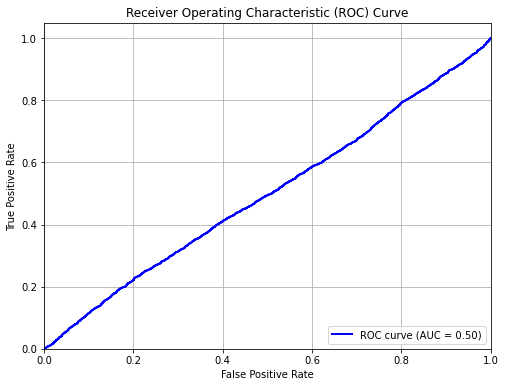

In [35]:
plot_ROC_or_PR(df, y_col = "gobp_label", scores_col = "correlation")

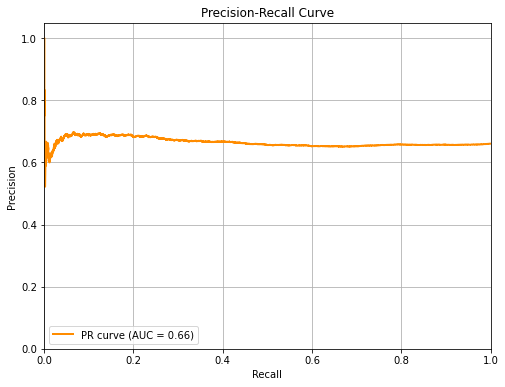

In [36]:
plot_ROC_or_PR(df, metric_type ="PR", y_col = "gobp_label", scores_col = "correlation")

## Cosine Similarity

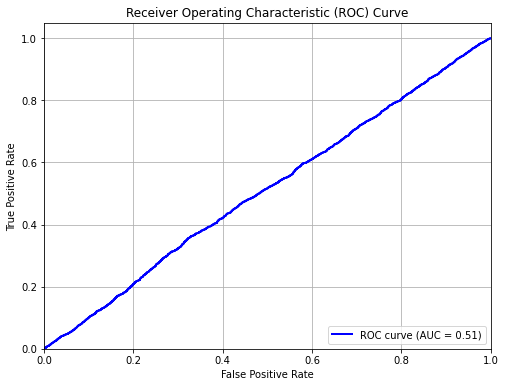

In [37]:
plot_ROC_or_PR(df, y_col = "gobp_label", scores_col = "cosine_similarity")

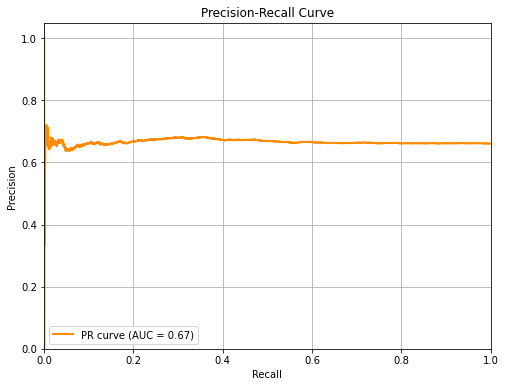

In [38]:
plot_ROC_or_PR(df, metric_type="PR", y_col = "gobp_label", scores_col = "cosine_similarity")

<AxesSubplot:>

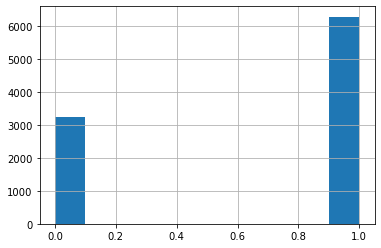

In [39]:
df['gobp_label'].hist()

<AxesSubplot:>

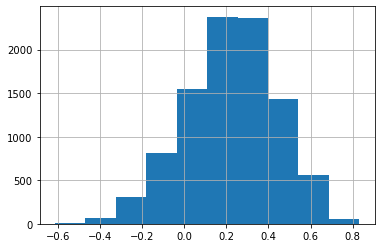

In [40]:
df['correlation'].hist()

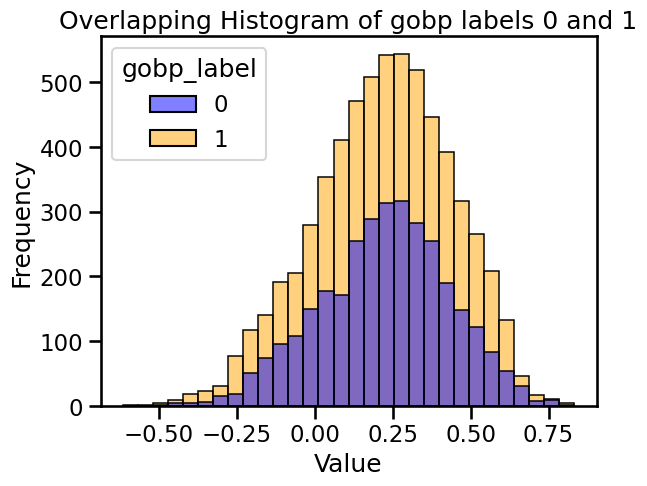

In [185]:
sns.histplot(df, x='correlation', hue='gobp_label', bins=30, palette={0: 'blue', 1: 'orange'}, alpha=0.5)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Overlapping Histogram of gobp labels 0 and 1')
plt.show()

In [41]:
df['correlation'].describe()

count    9524.000000
mean        0.221346
std         0.216205
min        -0.613765
25%         0.079540
50%         0.231991
75%         0.374789
max         0.831633
Name: correlation, dtype: float64

<AxesSubplot:>

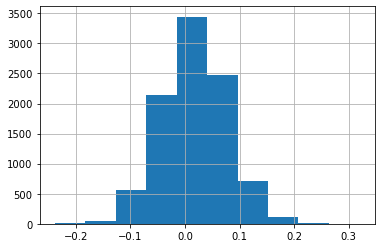

In [42]:
df['cosine_similarity'].hist()

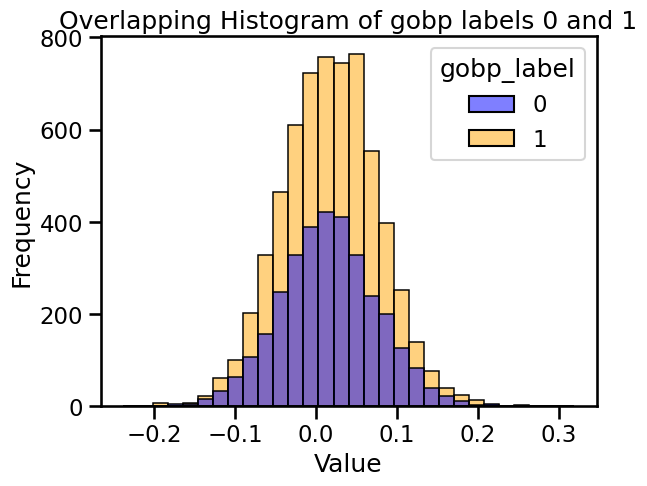

In [187]:
sns.histplot(df, x='cosine_similarity', hue='gobp_label', bins=30, palette={0: 'blue', 1: 'orange'}, alpha=0.5)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Overlapping Histogram of gobp labels 0 and 1')
plt.show()

In [43]:
df['cosine_similarity'].describe()

count    9524.000000
mean        0.017319
std         0.058989
min        -0.238432
25%        -0.022539
50%         0.017456
75%         0.056186
max         0.319122
Name: cosine_similarity, dtype: float64